# Edge Computing using Tensorflow and Neural Compute Stick

## " Generate piano sounds using EEG capturing rhythmic activity of brain"

### Contents

#### 1. Motivation
#### 2. Signal acquisition
#### 3. Signal postprocessing
#### 4. Synthesize music 
#####      4.1 Training Data
#####      4.2 Training data preprocessing
#####      4.3 Neural Network architecture
#####      4.4 Training methodology
####  5. Error definition and Further development


### 1. Motivation
The following work is inspired by EEG. EEG can be described in terms of rhythmic cortical electrical activity  of brain triggered by perceived sensory stimuli , where those rythmic activity falls in certain frequency bands(delta to gamma). In sound engineering, signals with dominant frequencies makes a pitch and sequences of pitches creates rhythm. Combining this concepts intuitively shows, by detecting those dominant frequencies, it is possible to listen to our brain using the signals it generates for different stimuli. Using principles of sound synthesis and sampling along with deep neural networks(DNN), in this project, i made an attempt to extract the rhythm or pitch hidding within brain waves and reproduce it as piano music. 

### 2. Signal acquisition: (Not available)

EEG/EOG recordings are not available. For the sake of simplicity and bring general working prototype of the model, used some random auto generated signal for test. This is because, the trained DNN is not constrained within brain waves, but to any kind of signal with dominant frequencies. Piano data set available for none commercial use is used during training and evaluation phase.

### 3. Signal Postprocessing (idea proposed)

Enough researches proved, "brain waves are rhytmic"[2] and they falls in frequency bandwidth from Delta(<4Hz) to Gamma (>30-100Hz). Human audible frequecy range 20 - 20KHz. Hence, increasing the acquired EEG freuencies by certain constant value and preprocess with sampling rate 44100 makes it resembles piano sounds (fundamental frequency range 27.5 - 4186.01Hz), which itself within human audible range. Later, save the processed brain signals as numpy arrays and convert them as .wav files to reproduce the sound. Using the .wav files to extract brain signal (now sound) informations (frequencies, sampling rate and pitch). In case, we succeed to regenerate the sounds, since we increased the signal frequency by constant (to fit our piano data), the sounds plays faster. Hence we need to reduce the frequency by the same value while replaying the sound that fits the original brain signal.

### 4. Synthesize music

#### 4.1 Training data

Piano chords dataset available to public for non commercial purposes 
[3]. Each piano .wav files in the data set are sampled at 44100 and have varying data length. Data is analysed and studied further in detail from the code blocks below.


#### 4.2 Training data preprocessing

######  Import required python libraries and add the current working directory to python path and system paths

Directory structure
<br>
<br>
Wavenet/

    -/dataset   (downloaded piano chords)
    
        - /UMAPiano-DB-Poly-1/UMAPiano-DB-A0-NO-F.wav
        
    -/clipped_data (clipped paino sounds are here)
    
    -/wavenet_logs  (tensorflow checkpoints and logs)

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import random
import scipy.io.wavfile
import scipy
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

#-------------------------------------Add working directory to path-----------------------------------------------

cwd = os.getcwd()
sys.path.append(cwd)
sys.path.insert(0,'E:/!CogSci/!!!WS2017/Edge_computing/Wavenet')    
sys.path.insert(0,'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset')
sys.path.insert(0,'E:/!CogSci/!!!WS2017/Edge_computing/Wavenet/clipped_data')
# Save the variables in a log/directory during training

save_path = "C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/wavenet_logs"
if not os.path.exists(save_path):
    os.makedirs(save_path)



Each piano file from the dataset is approximately 1-2 seconds in length. We used the scipy to read each music file and get their sampling rate and data as array and found that all audio files has sampling rate 44100 and the data length varies based on length of audio. To train DNN, we need all training data with same length and increase the sampling rate to prevent signal loss/corruption. Below code shows the acquisition of first information about the piano dataset. 

Sample rate1 44100  data size1 (96271,)  duration1: 2.183015873015873 seconds
Sample rate2 44100  data size2 (95642,)  duration2: 2.1687528344671203 seconds
DATA SIZES ARE DIFFERENT NEEDS TO BE CONSIDERED


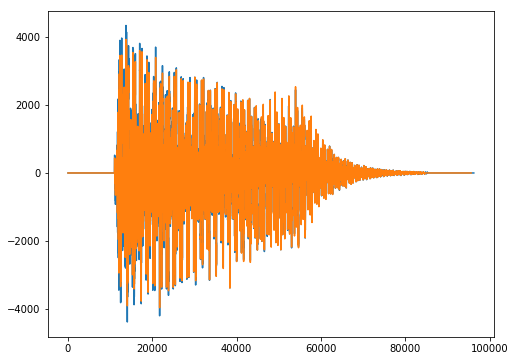

In [3]:
# Location of the wav file in the file system.

fileName1 = 'E:/!CogSci/!!!WS2017/Edge_computing/Wavenet/dataset/UMAPiano-DB-Poly-1/UMAPiano-DB-A0-NO-F.wav'
fileName2 = 'E:/!CogSci/!!!WS2017/Edge_computing/Wavenet/dataset/UMAPiano-DB-Poly-1/UMAPiano-DB-A0-NO-M.wav'

# Loads sample rate (bps) and signal data (wav). 

sample_rate1, data1 = scipy.io.wavfile.read(fileName1)
sample_rate2, data2 = scipy.io.wavfile.read(fileName2)


# Print in sdout the sample rate, number of items and duration in seconds of the wav file
print("Sample rate1 %s  data size1 %s  duration1: %s seconds"%(sample_rate1,data1.shape,len(data1)/sample_rate1))
print("Sample rate2 %s  data size2 %s  duration2: %s seconds"%(sample_rate2,data2.shape,len(data2)/sample_rate2))
print("DATA SIZES ARE DIFFERENT NEEDS TO BE CONSIDERED")

# Plot the wave file and get insight about the sample. Here we test first 100 samples of the wav file

plt.plot(data1)
plt.plot(data2)
plt.show()




Looking at the plot above, it is clear that there is no signal informations at the head and tail of the piano data. We can clip them safely and that reduces computation and memory resources. Also, i changed all the data file names with numbers for convenient. Later, i checked the files with shortest and longest length to fix varying length problem in the code block below.

Max sized file is 356.wav
Minimum sized file is 722.wav
Maximum size 181718 
Minimum size 39224 
Dataset is in C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset and all the files are numbered
Sample rate3 44100  data size3 (181718,)  duration3: 4.120589569160998 seconds
Sample rate4 44100  data size4 (39224,)  duration4: 0.8894331065759638 seconds
Data sizes are different
0
0
0
0


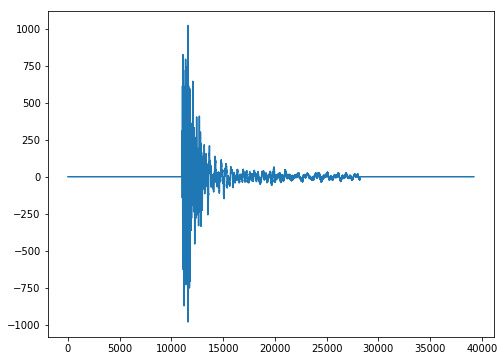

Safe to clip first 10000 sample points out from the array and convert them back to .wav file


In [4]:
"""
dataset_path = 'E:/!CogSci/!!!WS2017/Edge_computing/Wavenet/dataset/UMAPiano-DB-Poly-1'
dir_list_len = len(os.listdir(dataset_path))
print("Number of files in the Dataset ",dir_list_len)

# Change file names to be easily recognized

def change_filenames(dataset_path):
    
    i = 0  # Counter and target filename
    
    for old_name in os.listdir(dataset_path):
        # os.rename(dataset_path + "/" + old_name, dataset_path + "/" + str(i) + '.wav')
        os.rename(os.path.join(dataset_path, old_name), os.path.join(dataset_path, str(i) + '.wav'))
        i+=1    

change_filenames(dataset_new)
list_sizes_new =[]  

for data_new in os.listdir(dataset_new):
    _,data_new = scipy.io.wavfile.read(dataset_new+'/'+data_new)
    list_sizes_new.append(data_new.shape[0])
print("Maximum size %s and the music file is",np.argmax(list_sizes_new))

"""


dataset_new = 'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset'
list_sizes =[]  
for datas in os.listdir(dataset_new):
    _,data_new = scipy.io.wavfile.read(os.path.join(dataset_new,datas))
    list_sizes.append(data_new.shape[0])
    if data_new.shape[0]== 39224:
        print("Minimum sized file is",datas)
    if data_new.shape[0] == 181718:
        print("Max sized file is",datas)

print("Maximum size %s "%(max(list_sizes)))
print("Minimum size %s "%(min(list_sizes)))

print("Dataset is in C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset and all the files are numbered")

# -------------------------Get some insights and information about the max and min sized data-----------------------------

# Location of the wav file in the file system.
fileName3 = 'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset/356.wav'
fileName4 = 'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset/722.wav'
# Loads sample rate (bps) and signal data (wav). 
sample_rate3, data3 = scipy.io.wavfile.read(fileName3)
sample_rate4, data4 = scipy.io.wavfile.read(fileName4)


# Print in sdout the sample rate, number of items and duration in seconds of the wav file
print("Sample rate3 %s  data size3 %s  duration3: %s seconds"%(sample_rate3,data3.shape,len(data3)/sample_rate3))
print("Sample rate4 %s  data size4 %s  duration4: %s seconds"%(sample_rate4,data4.shape,len(data4)/sample_rate4))
print("Data sizes are different")

# Plot the wave file and get insight about the sample. Here we test first 100 samples of the wav file

plt.plot(data4)
plt.show()

print("Safe to clip first 10000 sample points out from the array and convert them back to .wav file")

As we can see that even the smallest piano file has 20k values of zeros at head and tail combined. Hence it is safe to clip the first and last 10k indices from all files and save them back to .wav files. We can also add small amount of noise to the training data at this step using the code below. We will discuss the reason later briefly.

Sample rate 44100  data size (56293,)  duration: 1.2764852607709751 seconds


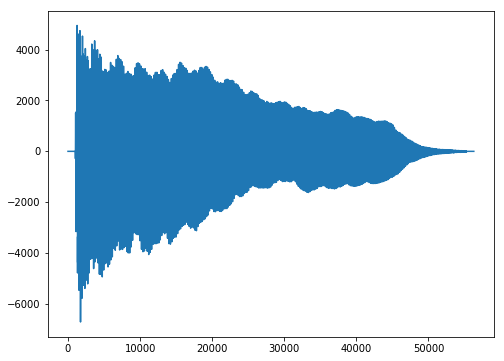

In [5]:
#----------------------- .WAV training data preprocessing steps ----------------------
import IPython

# Clip the first and last 10000 values which doesn't show any informations 
"""
def clip_write_wav(dataset_path):
    
    i = 0  # Counter and target filename
    
    for datas in os.listdir(dataset_path):
        
        _,data = scipy.io.wavfile.read(dataset_path+'/'+datas)
        data= data[:-10000]  # Slice out last 10000 elements in data
        data= data[10000:] # Slice out first 10000 elements in the data
        
        #IF ADD NOISE DO it here in the data which is an array.
        
        scipy.io.wavfile.write('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/clipped_data/%i.wav'%i, 44100, data) 
        
        i+=1        
    
 """

_dataset = 'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/dataset'
_target = 'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/clipped_data'
clip_points = 10000
_sampling_rate = 44100

# clip_write_wav(_dataset)   # Uncomment this line to clip  and write the wav files again


# Verify required informations again
sample_rate3, data3 = scipy.io.wavfile.read('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/clipped_data/3.wav')
print("Sample rate %s  data size %s  duration: %s seconds"%(sample_rate3,data3.shape,len(data3)/sample_rate3))
plt.plot(data3)
plt.show()

#Play the audio inline

IPython.display.Audio('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/clipped_data/3.wav')



The data are clipped and they have shorter neck and tail now. Now we will increase the sampling rate (using "write_wav" function below) and fix the varying length in data by choosing the data with longest length as reference and zero padd other data until their length matches the length of the largest file done while feeding DNN using "get_training_data" function below .
<br>
But the scipy read module doesn't preserve the indices of the files in the dataset, as we can see that the largest and smallest file names from code block above and below are different. So, i hard coded the size of smallest and largest and search for the corresponding files.



In [6]:
# ------------- Search for the largest and smallest files --------------

_dataset_new = 'C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/clipped_data'
_list_sizes =[]  

for datas in os.listdir(_dataset_new):
    _,_data_new = scipy.io.wavfile.read(os.path.join(_dataset_new,datas))
    _list_sizes.append(_data_new.shape[0])
    if _data_new.shape[0]== 19224:
        print("Minimum sized file is",datas)
    if _data_new.shape[0] == 161718:
        print("Max sized file is",datas)

print("Maximum size %s "%(max(_list_sizes)))
print("Minimum size %s "%(min(_list_sizes)))
print("Notice that io read and write doesnt preserve the index of files in the directory")

Max sized file is 286.wav
Minimum sized file is 693.wav
Maximum size 161718 
Minimum size 19224 
Notice that io read and write doesnt preserve the index of files in the directory


In [7]:
# ------------------------ Upsample the data -----------------------------
"""
def write_wav(dataset_path):
    i=0
    for datas in os.listdir(dataset_path):
        
        _,data = scipy.io.wavfile.read(dataset_path+'/'+datas)
        
        #IF ADD NOISE DO it here in the data which is an array.
        
        scipy.io.wavfile.write('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/upsampled_data/%i.wav'%i, 88000, data) 
        
        i+=1

write_wav(_dataset_new)
"""

"\ndef write_wav(dataset_path):\n    i=0\n    for datas in os.listdir(dataset_path):\n        \n        _,data = scipy.io.wavfile.read(dataset_path+'/'+datas)\n        \n        #IF ADD NOISE DO it here in the data which is an array.\n        \n        scipy.io.wavfile.write('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/upsampled_data/%i.wav'%i, 88000, data) \n        \n        i+=1\n\nwrite_wav(_dataset_new)\n"

Max sized file is 208.wav and sampling rate 88000
Minimum sized file is 660.wav and sampling rate 88000
Maximum size 161718 
Minimum size 19224 
Sample rate 88000  data size (49966,)  duration: 0.5677954545454545 seconds


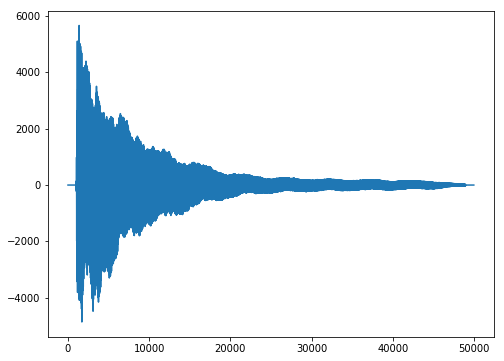

In [8]:
# ----------------- Verifying data integrity again -----------------------

sampled_datapath ='C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/upsampled_data'
_list_sizes =[] 

for datas in os.listdir(sampled_datapath):
    sampling_rate,_data_new = scipy.io.wavfile.read(os.path.join(sampled_datapath,datas))
    _list_sizes.append(_data_new.shape[0])
    
    if _data_new.shape[0]== 19224:
        print("Minimum sized file is %s and sampling rate"%datas,sampling_rate)
    
    elif _data_new.shape[0] == 161718:
        print("Max sized file is %s and sampling rate"%datas,sampling_rate)


print("Maximum size %s "%(max(_list_sizes)))
print("Minimum size %s "%(min(_list_sizes)))


# Verify required informations again

sample_rate5, data5 = scipy.io.wavfile.read('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/upsampled_data/3.wav')
print("Sample rate %s  data size %s  duration: %s seconds"%(sample_rate5,data5.shape,len(data5)/sample_rate5))
plt.plot(data5)
plt.show()

#Play the audio inline

IPython.display.Audio('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/clipped_data/3.wav')

Since, we use stacks of CNN in the encoder, i decided to convert the data as matrix of size 512*512 for which 
we need each file to have 262144 entries. So, instead of using largest file as reference, i opted 262144 as a length limit for all files. Function "get_training_data" serve this purpose for us.

In [9]:

# Each audio file should have 262144 entries. Extend them all with zeros in the tail
# Convert all audio files as matrices of 512x512 shape

def get_training_data(dataset_path):
    
    training_data  = []
    
    for datas in os.listdir(dataset_path):
        
        _,data = scipy.io.wavfile.read(dataset_path+'/'+datas)
        # Add Zeros at the tail until 262144
        temp_zeros = [0]*262144

        temp_zeros[:len(data)] = data  # Slice temp_zeros and add the data into the slice

        # Reshape the data as square matrix of 512*512 of size 262144
        data_ = np.reshape(temp_zeros,(512,512))
        training_data.append(data_)
    
    return training_data

training_data = get_training_data('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/upsampled_data')

print(training_data[0].shape)

# Expand the dims # The third dimension represents number of channels

for i in range(len(training_data)):
    training_data[i] = training_data[i][:,:,np.newaxis]
print(training_data[0].shape)
   


(512, 512)
(512, 512, 1)


The training data is ready to be fed into the network. But we still require the pitch info about each training data, since the network architecture we use require them while training. Class "HarmonicPowerSpectrum" and the nesxt two code blocks are bandpass filtering the signal that ease pitch detection.
    

Bandpass filter with order 1 looks okay. We do not want to loose much informations in the data by filter it with higher orders


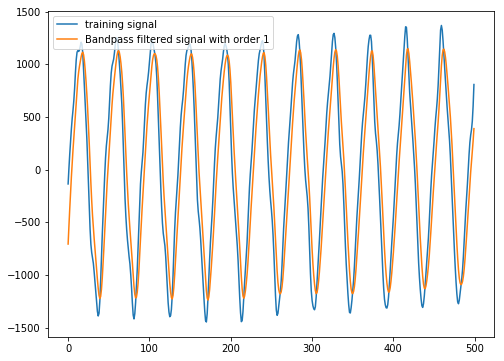

In [11]:
# Get pitch of corresponding data

"""
Steps to extract the pitches of input signal:
Reference:
https://stackoverflow.com/questions/43946112/slicing-audio-signal-to-detect-pitch

1.  Detect the fundamental frequencies "f0 estimation" (For piano, lowest freq - 27.5 and highest - 4186.01 Hz)
2.  Get ride of garbage transients and low frequency noise using bandpass filter 
3.  After filtering do the peak detection using fft to find the pitches 
"""

# 1. Fundamental frequencies [27.5,4186.01] Hz
# 2. Build bandpass fileter

from scipy.signal import butter, lfilter

def butter_bandpass(f0, fs, order):
    
    """Give the Sampling freq(fs),Bandpass window(f0) of filter, build the bandpass filter"""
    
    nyq = 0.5 * fs
    low = f0[0] / nyq
    high = f0[1] / nyq
    b, a = butter(order, [low, high], btype='band')  # Numerator (b) and denominator (a) polynomials of the IIR filter
    
    return b, a

def butter_bandpass_filter(sig, f0, fs, order):
    
    """ Apply bandpass filter to the given signal"""
    
    b, a = butter_bandpass(f0, fs,order)
    y = lfilter(b, a, sig)    # Apply the filter to the signal
    
    
    return y  
 
# Verify filter signal 
sig = data5
f0= (27.5, 4186.01)  # Fundamental freq of piano
fs = sample_rate5 # sampling rate of .wav files in the preprocessed training dataset
order = 1
b, a = butter_bandpass(f0, fs, order=1)  # Numerator (b) and denominator (a) polynomials of the IIR filter
filtered_sig= butter_bandpass_filter(sig, f0,fs,order=1)

# Plot some range of samples from both raw signal and bandpass fitered signal.

plt.plot(sig[10000:10500], label='training signal')
plt.plot(filtered_sig[10000:10500], label='Bandpass filtered signal with order %d'% order)
plt.legend(loc='upper left')

# orders = [1,2,3,4,5]
# for order in orders:
#     filtered_sig= butter_bandpass_filter(sig, f0,fs,order)  # Bandpass filtered signal
#     plt.plot(data5[10000:10500], label='training signal')
#     plt.plot(filtered_sig[10000:10500], label='Bandpass filtered signal with order %d'% order)
#     plt.legend(loc='upper left')

print("Bandpass filter with order 1 looks okay. We do not want to loose much informations in the data by filter it with higher orders")



c:\users\saran\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


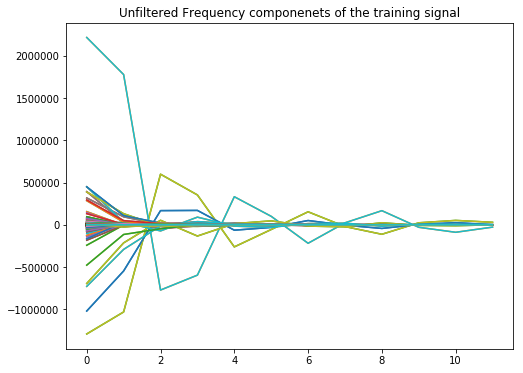

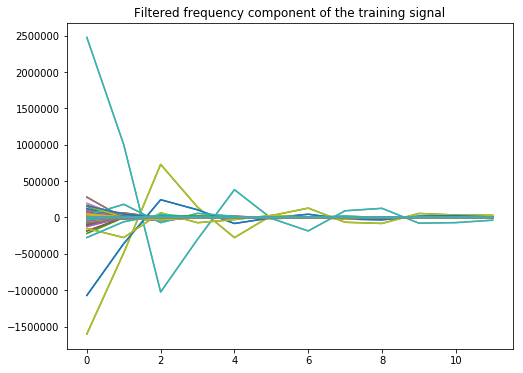

In [12]:
# Reference :https://github.com/pydanny/pydanny-event-notes/blob/master/Pycon2008/intro_to_numpy/files/pycon_demos/windowed_fft/short_time_fft_solution.py
# Get frequency components of the data using Short time fourier transform

from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import get_window
from math import ceil
from pylab import figure, imshow, clf, gray, xlabel, ylabel


sig = data5
f0= (27.5, 4186.01)  # Fundamental freq of piano
fs = sample_rate5 # sampling rate of .wav files in the preprocessed training dataset


def freq_comp(signal,sample_rate):
    
    # Define the sample spacing and window size.
    dT = 1.0/sample_rate
    T_window = 50e-3   # 50ms ; window time frame
    N_window = int(T_window * sample_rate)  # 440  
    N_data = len(signal)  

    # 1. Get the window profile
    window = get_window('hamming', N_window)   # Multiply the segments of data using hamming window func

    # 2. Set up the FFT
    result = []
    start = 0
    while (start < N_data - N_window):
        end = start + N_window
        result.append(fftshift(fft(window*signal[start:end])))
        start = end

    result.append(fftshift(fft(window*signal[-N_window:])))
    result = np.array(result,result[0].dtype)
    
    return result

freq_comp_unfiltered = freq_comp(sig,fs)
freq_comp_filtered = freq_comp(filtered_sig,fs)
plt.figure(1)
plt.plot(freq_comp_unfiltered)
plt.title("Unfiltered Frequency componenets of the training signal")
plt.show()
plt.figure(2)
plt.plot(freq_comp_filtered)
plt.title("Filtered frequency component of the training signal")
plt.show()


# # Display results
# freqscale = fftshift(fftfreq(N_window,dT))[150:-150]/1e3
# figure(1)
# clf()
# imshow(abs(result[:,150:-150]),extent=(freqscale[-1],freqscale[0],(N_data*dT-T_window/2.0),T_window/2.0))
# xlabel('Frequency (kHz)')
# ylabel('Time (sec.)')
# gray()


In [13]:
# Reference: http://musicweb.ucsd.edu/~trsmyth/analysis/Harmonic_Product_Spectrum.html
# Get the fundamental frequency(peak frequency) of the training data

import parabolic
from pylab import subplot, plot, log, copy, show

# def hps(sig,fs,maxharms):
    
#     """
#     Estimate peak frequency using harmonic product spectrum (HPS)
#     """
#     window = sig * scipy.signal.blackmanharris(len(sig))

#     # Harmonic product spectrum: Measures the maximum coincidence for harmonics for each spectral frame
    
#     c = abs(np.fft.rfft(window))  # Compute the one-dimensional discrete Fourier Transform for real input.
#     plt.plot(c)
#     plt.title("Discrete fourier transform of signal")
#     plt.figure()
#     pitch = np.log(c)
#     plt.plot(pitch)
#     plt.title("Max Harmonics for the range same as fundamental frequencies")
    
#       # Search for a maximum value of a range of possible fundamental frequencies
# #     for x in range(2, maxharms):
# #         a = copy(c[::x])  # Should average or maximum instead of decimating
# #         c = c[:len(a)]
# #         i = np.argmax(abs(c))
# #         c *= a
# #         plt.title("Max Harmonics for the range of %d times the fundamental frequencies"%x)
# #         plt.plot(maxharms, x)
# #         plt.plot(np.log(c))
# #     show()

# hps(butter_bandpass_filter(sig,f0, fs,order = 1),fs,maxharms=0)
# print(" As usual we opt to choose the same range as fundamental frequecies to make sure we dont loss much informations")

c:\users\saran\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


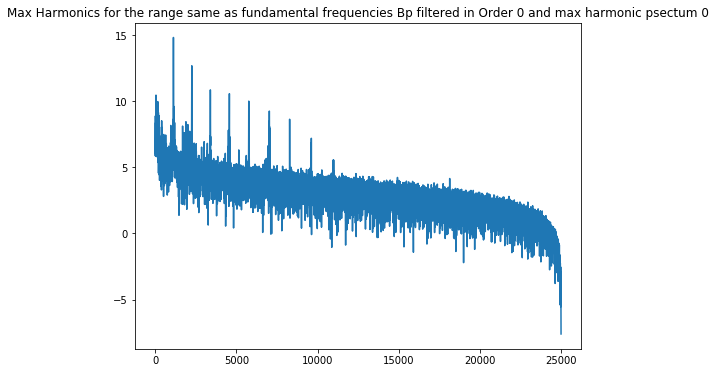

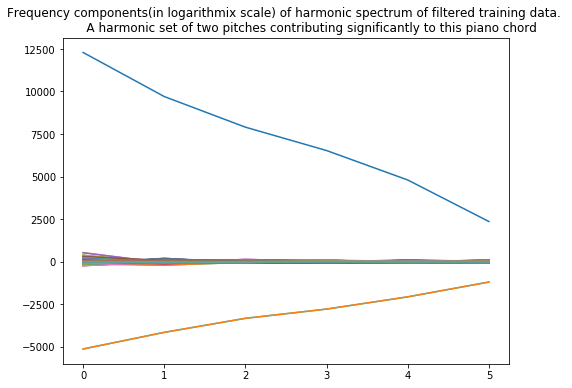

In [14]:
# Wrap them all in one class HarmonicPowerSpectrum

class HarmonicPowerSpectrum(object):
    
    def __init__(self,sig,f0,fs,order,maxharms):
        self.sig = sig
        self.f0 = f0
        self.fs = fs
        self.order = order
        self.maxharms = maxharms

    @property    
    def butter_bandpass(self):
    
        """Give the Sampling freq(fs),Bandpass window(f0) of filter, build the bandpass filter"""
    
        nyq = 0.5 * fs    # Nyquist frequency
        low = self.f0[0] / nyq
        high = self.f0[1] / nyq
        b, a = butter(self.order, [low, high], btype='band')  # Numerator (b) and denominator (a) polynomials of the IIR filter

        return b, a

    @property
    def butter_bandpass_filter(self):
    
        """ Apply bandpass filter to the given signal"""
    
        b, a = self.butter_bandpass
        y = lfilter(b, a, self.sig)    # Apply the filter to the signal

        return y 

    @property
    def hps(self):
    
        """Estimate peak frequency using harmonic product spectrum (HPS)"""
        
        y = self.butter_bandpass_filter
        window = y * scipy.signal.blackmanharris(len(y))  #Create window to search harmonics in signal slices

        # Harmonic product spectrum: Measures the maximum coincidence for harmonics for each spectral frame
        
        c = abs(np.fft.rfft(window))  # Compute the one-dimensional discrete Fourier Transform for real input.
        z = np.log(c)  # Fundamental frequency or pitch of the given signal  

        return z
 
    
z = HarmonicPowerSpectrum(sig, f0, fs, order = 1,maxharms=0)
harm_pow_spec = z.hps
plt.figure(1)
plt.plot(harm_pow_spec)
plt.title("Max Harmonics for the range same as fundamental frequencies Bp filtered in Order 0 and max harmonic psectum 0")
freq_comp_hps = freq_comp(harm_pow_spec,fs)
plt.figure(2)
plt.plot(freq_comp_hps)
plt.title("""Frequency components(in logarithmix scale) of harmonic spectrum of filtered training data. 
             A harmonic set of two pitches contributing significantly to this piano chord""")
plt.show()



Hence, i updated the get_training_data function to perform pitch detection using the HarmonicPowerSpectrum analyser 
as seen below.

In [16]:
# Each audio file should have 262144 entries. Extend them all with zeros in the tail
# Convert all audio files as matrices of 512x512 shape

def get_training_data(dataset_path, f0, fs, order = 1,maxharms=0):
    
    training_data  = []
    pitch_data = []
    
    for datas in os.listdir(dataset_path):
        
        _,data = scipy.io.wavfile.read(dataset_path+'/'+datas)
        # Add Zeros at the tail until 162409
        temp_zeros_data = [0]*262144
        # print("Unpadded data len",len(data))
        # print(len(temp_zeros))
        temp_zeros_data[:len(data)] = data  # Slice temp_zeros and add the data into the slice
        # print("Padded data len",len(temp_zeros))
        # print(np.shape(temp_zeros))
        # Reshape the data as square matrix of 403*403 of size 162409
        data_ = np.reshape(temp_zeros_data,(512,512))
        # Get pitch of the signal
        z = HarmonicPowerSpectrum(temp_zeros_data, f0, fs, order = 1,maxharms=0)
        harm_pow_spec = z.hps
        
        training_data.append(data_)
        pitch_data.append(harm_pow_spec)
    
    return training_data,pitch_data

training_data,pitch_data = get_training_data('C:/Users/Saran/!!!!!!!!!!!!!Edge_computing/Wavenet/upsampled_data',f0, fs, order = 1,maxharms=0)


print(training_data[0].shape)

# Expand the dims # The third dimension represents number of channels

for i in range(len(training_data)):
    training_data[i] = training_data[i][:,:,np.newaxis]
print(training_data[0].shape)

(512, 512)
(512, 512, 1)
